# Building a Naïve Bayes Spam Filter

We will use the SMS spam collection dataset from: https://archive.ics.uci.edu/ml/machine-learning-databases/00228/

The dataset provides 5572 sms classified as spam and non-spam (ham)

We are going to try two different classifiers, which take different approaches:
- **Bernoulli**: models the presence/absence of a feature
- **Multinomial**: models the number of counts of a feature

In [1]:
# import libraries

import pandas as pd
import numpy as np
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('SMSSpamCollection', header = None, sep='\t')
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing data

We will:
- Lower case
- Remove numbers
- Remove punctuation
- Remove stopwords

In [4]:
import nltk
from string import punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hernan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def to_lower(text):
    """
    Converting text to lower case as in, converting "Hello" to  "hello" or "HELLO" to "hello".
    """
    return ' '.join([w.lower() for w in nltk.word_tokenize(text)])

In [6]:
processed_sms = []
for i in range(len(df)):
    #process sms into lower cases
    lower = to_lower(df.iloc[i][1])
    
    #remove numbers in the sms
    remove_numbers = ''.join(c for c in lower if not c.isdigit())
    
    #remove punctuations in the sms
    remove_punc = ''.join(c for c in remove_numbers if c not in punctuation)
    
    #remove stopwords
    word_tokens = nltk.word_tokenize(remove_punc)
    remove_stopwords = [word for word in word_tokens if word not in stopword]
    processed_sms.append(remove_stopwords)
df['processed sms']=processed_sms
df.head()

,0,1,processed sms
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, nt, think, goes, usf, lives, around, tho..."


### Shuffle and split the data

In [7]:
#shuffle the data
df_shuffled = df.iloc[np.random.permutation(len(df))]
df_shuffled = df_shuffled.reset_index(drop=True)


In [8]:
df_shuffled.shape

(5572, 3)

In [9]:
#split 2/3 into training data amd 1/3 test data
training_data = df_shuffled.iloc[0:3715].copy()
test_data = df_shuffled.iloc[3715:].copy()

### Create occurrence matrix 

In [10]:
#create input binary variables on the existence of specific words
vocabulary = list(set(training_data['processed sms'].sum()))
word_check = pd.DataFrame(np.zeros((3715, len(vocabulary))),columns = vocabulary)
word_check.head()

,leaves,bleh,classmates,spend,yep,heavy,quitting,raji,kudi,dointerested,...,mmm,sack,knee,endowed,fifa,excuses,page,runs,careumma,compromised
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
for i in range(len(training_data)):
    for word in training_data['processed sms'][i]:
        if word in vocabulary:
            word_check[word][i] = 1
word_check.head()

,leaves,bleh,classmates,spend,yep,heavy,quitting,raji,kudi,dointerested,...,mmm,sack,knee,endowed,fifa,excuses,page,runs,careumma,compromised
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
training_x = word_check.copy()
#set output variable as binary as well. spam = 1, ham = 0
training_y = []
for i in range(len(training_data)):
    if training_data.iloc[i,0]=='spam':
        training_y.append(1)    
    else:
        training_y.append(0)

## Bernoulli Naïve Bayes classifier

In [13]:
#fit Bernoulli naive bayes classifier using training data
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(training_x, training_y)

BernoulliNB()

In [14]:
test_data = test_data.reset_index(drop=True)

In [15]:
#create binary input variables for test data using the same vocabulary as training data
test_word_check = pd.DataFrame(np.zeros((1857, len(vocabulary))),columns = vocabulary)
for i in range(len(test_data)):
    for word in test_data['processed sms'][i]:
        if word in vocabulary:
            test_word_check[word][i] = 1
test_word_check

,leaves,bleh,classmates,spend,yep,heavy,quitting,raji,kudi,dointerested,...,mmm,sack,knee,endowed,fifa,excuses,page,runs,careumma,compromised
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
test_x = test_word_check.copy()
#create binary output variable
test_y = []
for i in range(len(test_data)):
    if test_data.iloc[i,0]=='spam':
        test_y.append(1)    
    else:
        test_y.append(0)

In [17]:
clf.predict(test_x)

array([0, 0, 0, ..., 0, 1, 0])

In [18]:
#assess the performance on test data
clf.score(test_x, test_y)

0.962843295638126

#### Confusion matrix

In [19]:
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score
#calculate accuracy score and classification matrics for Bernoulli Naive Bayes classifier on test data
test_predict_bin = clf.predict(test_x)
print ('Accuracy Score: ', accuracy_score(y_true=test_y, y_pred = test_predict_bin))
print(classification_report(y_true = test_y, y_pred = test_predict_bin))

Accuracy Score:  0.962843295638126
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1612
           1       0.99      0.73      0.84       245

    accuracy                           0.96      1857
   macro avg       0.97      0.86      0.91      1857
weighted avg       0.96      0.96      0.96      1857



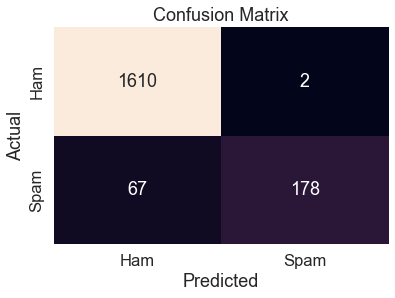

In [20]:
#show confusion matrix for Bernoulli Naive Bayes classifier on test data
cm = sklearn.metrics.confusion_matrix(test_y,test_predict_bin)

sns.set(font_scale=1.5)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])
plt.show()

## Multinomial Naïve Bayes Classifier

In [21]:
#Fit Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb = mnb.fit(training_x, training_y)

In [22]:
#assess the performance on test data
mnb.score(test_x, test_y)

0.9806138933764136

#### Confusion matrix

In [23]:
#calculate accuracy score and classification matrics for Multinomial Naive Bayes classifier on test data
test_predict_mul = mnb.predict(test_x)
print ('Accuracy Score: ', accuracy_score(y_true=test_y, y_pred = test_predict_mul))
print(classification_report(y_true = test_y, y_pred = test_predict_mul))

Accuracy Score:  0.9806138933764136
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1612
           1       0.94      0.91      0.93       245

    accuracy                           0.98      1857
   macro avg       0.96      0.95      0.96      1857
weighted avg       0.98      0.98      0.98      1857



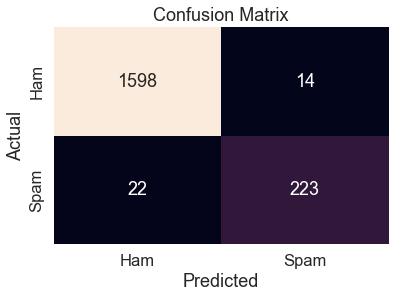

In [24]:
#show confusion matrix for Multinomial Naive Bayes classifier on test data
cm = sklearn.metrics.confusion_matrix(test_y,test_predict_mul)

sns.set(font_scale=1.5)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Ham', 'Spam'])
ax.yaxis.set_ticklabels(['Ham', 'Spam'])
plt.show()

In [25]:
df[0].value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

In [26]:
print('Proportion of spam sms: ', 747/(4825+747))

Proportion of spam sms:  0.13406317300789664


We see that both models reported a high accuracy on the test set, being **0.9752** for the **Bernoulli model** and **0.9865** for the **Multinomial model**. 

Additionally, checking the **confussion matrix** we see that there is a higher tendency on both models to report false negatives, instead of false positives, which could be expected due to the unbalanced dataset we are working with